In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.utils import shuffle
%matplotlib inline

Columns in all data sets: 
* mjj (TeV)
* mjmin (TeV)
* mjmax-mjmin (TeV)
* tau21(mjmin) 
* tau21 (mjmax)
* sigorbg label

# Full R&D dataset

In [2]:
LHCO_RD_dataset = pd.read_csv("../../data/full_LHCO_RnD.csv")
LHCO_RD_dataset['type'] = LHCO_RD_dataset['5'].map({0: "Background", 1: "Signal"})
LHCO_RD_dataset['5'].sum() / LHCO_RD_dataset.shape[0]

0.09090909090909091

In [3]:
def feature_hists(X, n_bins=101, stat="density", common_norm=True, highlight_SR=False):
    x_names = [r'$m_{jj}$ (TeV)', r'$m_{j1}$ (TeV)', r'$m_{j2}-m_{j1}$ (TeV)',
               r'$\tau_{21}^{j1}$', r'$\tau_{21}^{j2}$', 'Signal / Background, %']
    x_columns = X.columns
    X = X.copy()
    X['type'] = X['5'].map({0: "Background", 1: "Signal"})

    plt.figure(figsize=(5 * 3, 4 * 2))
    for i in range(X.shape[1] - 1):
        plt.subplot(2, 3, i + 1)
        bins = np.linspace(X[x_columns[i]].min(), X[x_columns[i]].max(), n_bins)
        stat = stat if i != 5 else "percent"
        sns.histplot(data=X, x=x_columns[i], stat=stat, element="step", hue="type",
                     bins=bins, linewidth=1, common_norm=common_norm)
        plt.xlabel(x_names[i], size=14)
        if i % 3 == 0:
            plt.ylabel(stat[0].upper() + stat[1:], size=14)
        elif i == 5:
            plt.ylabel('Percent', size=14)
        else:
            plt.ylabel(None)

        if i == 0 and highlight_SR:
            plt.axvline(3.3, linestyle="--", c="black", label="SR = [3.3; 3.7] TeV")
            plt.axvline(3.7, linestyle="--", c="black")
            plt.legend()
        plt.xticks(size=14)
        plt.yticks(size=14)
    plt.tight_layout()
    plt.show()

## Full domain

In [4]:
def draw_mjj_log_scale(X, is_SR=False):
    X = X[["0", "5"]].copy()
    X['type'] = X['5'].map({0: "Background", 1: "Signal"})
    bins = np.linspace(X["0"].min(), X["0"].max(), 101)
    
    sns.histplot(data=X, x="0", label="background+signal", 
                stat="count", element="step", bins=bins, linewidth=1, alpha=0.2)
    sns.histplot(x=X[X["5"] == 1]["0"], label="signal",
                stat="count", element="step", bins=bins, linewidth=1, alpha=0.2)
    sns.histplot(x=X[X["5"] == 0]["0"], label="background", fill=False, color="red",
                stat="count", element="step", bins=bins, linewidth=1, alpha=1)
    
    plt.xlabel(r'$m_{jj}$ (TeV)', size=14)
    plt.axvline(3.3, linewidth=0.7, linestyle="--", c="black", label="SR = [3.3; 3.7] TeV")
    plt.axvline(3.7, linewidth=0.7, linestyle="--", c="black")
    plt.legend(loc='upper right')
    if not is_SR:
        plt.xticks([i for i in range(1, 10)], size=14)
    plt.yticks(size=14)
    plt.yscale('log')

    sig_frac = round(X["5"].sum() / X.shape[0] * 100, 2)
    bg_frac = 100 - sig_frac
    if is_SR:
        t = plt.text(x=3.588, y=150, s=f"Signal: {sig_frac}%\nBackground: {bg_frac}%")
    else:
        t = plt.text(x=6.85, y=1200, s=f"Signal: {sig_frac}%\nBackground: {bg_frac}%")
    t.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='grey', mutation_scale=0.9))
    plt.show()

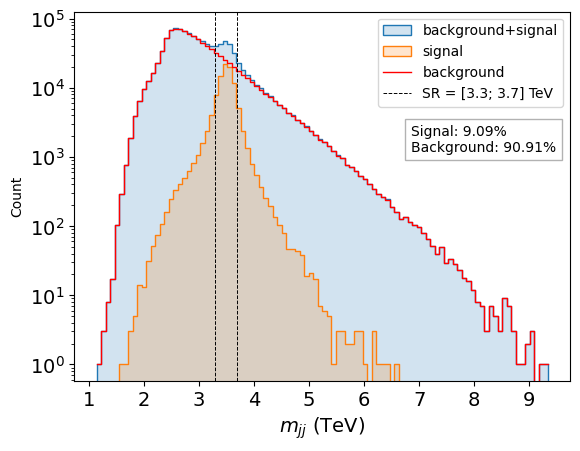

In [5]:
draw_mjj_log_scale(LHCO_RD_dataset)

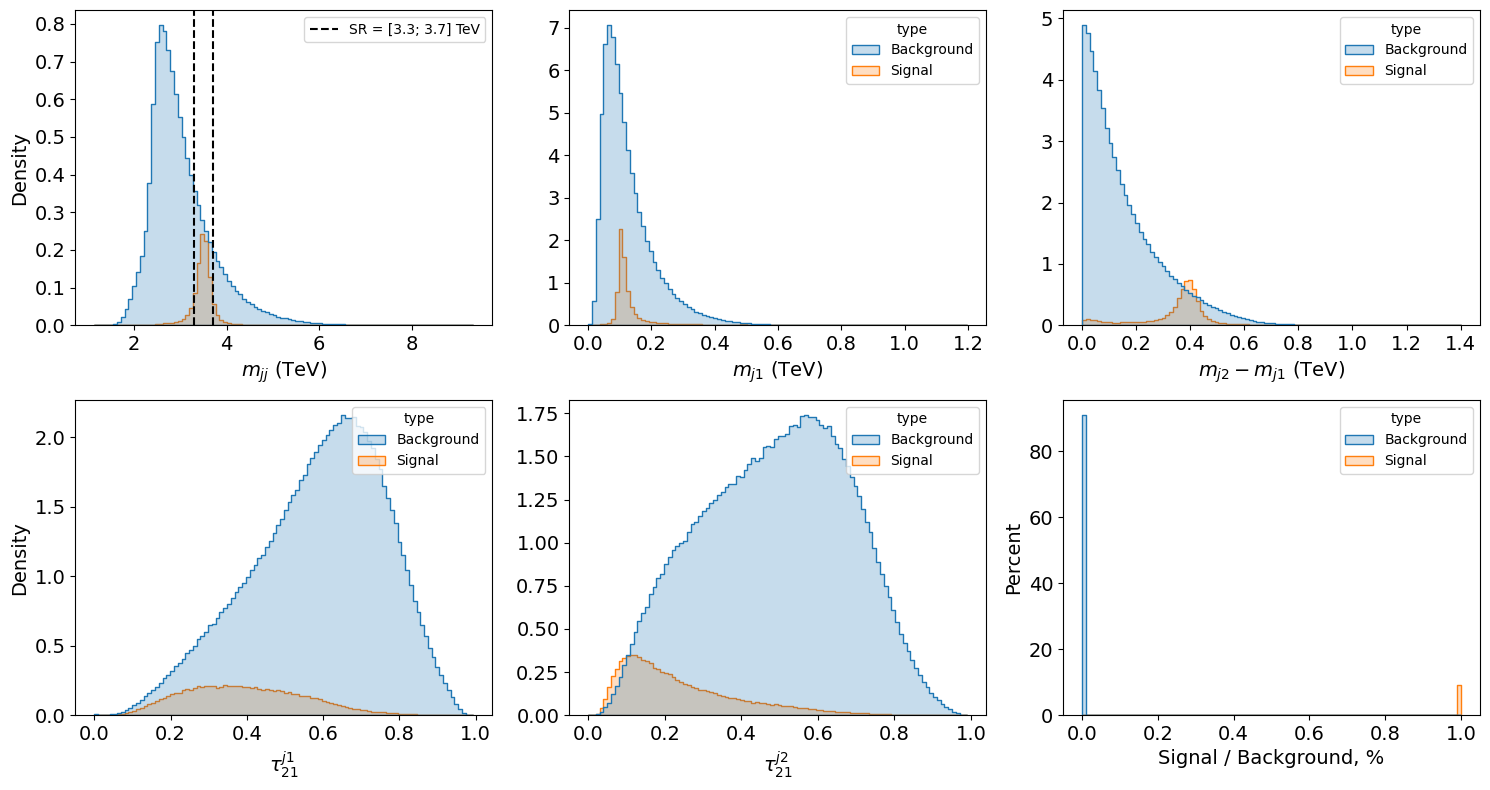

In [6]:
feature_hists(LHCO_RD_dataset, stat="density", common_norm=True, highlight_SR=True)

## Only SR

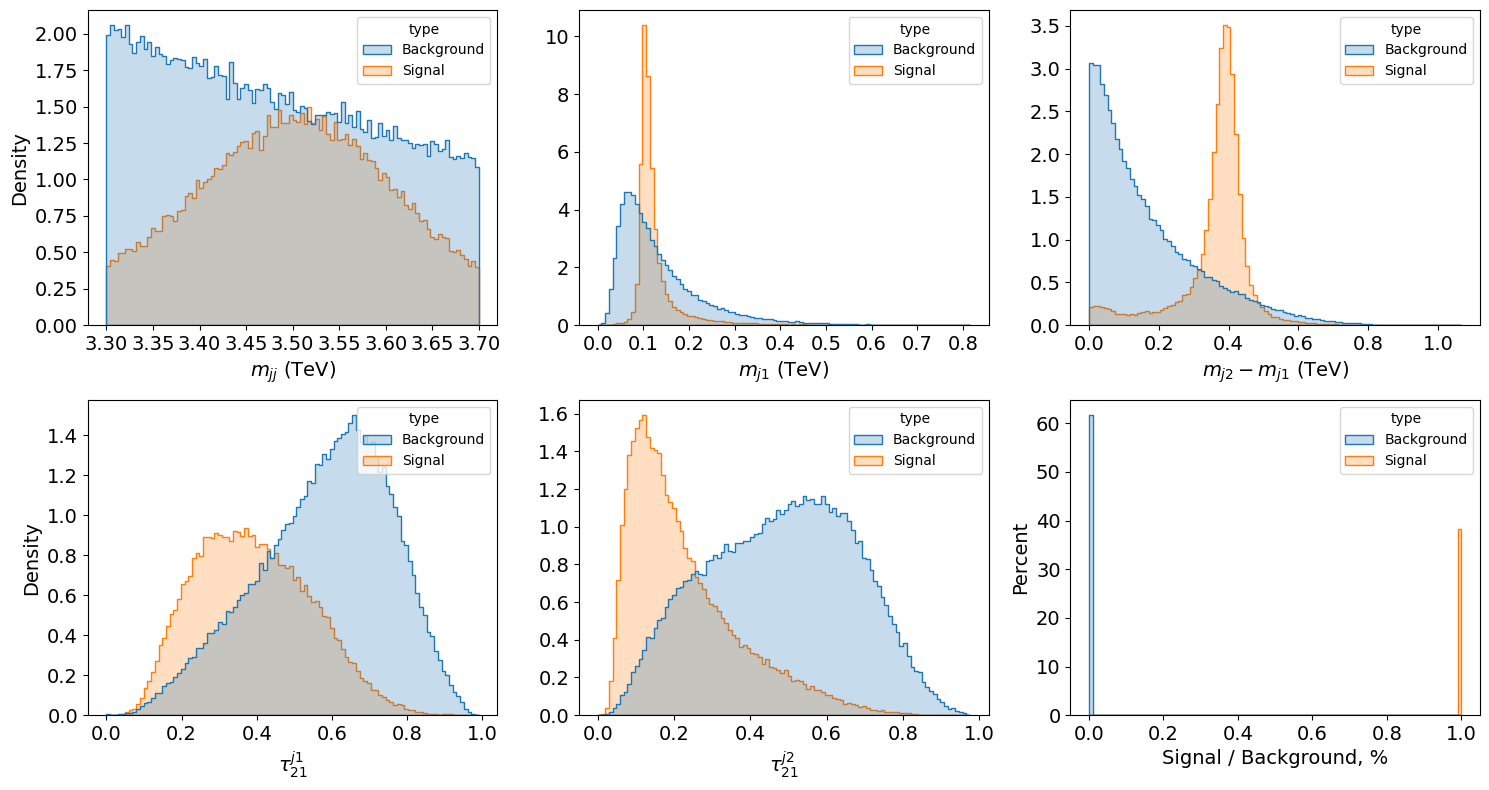

In [7]:
LHCO_SR = LHCO_RD_dataset.loc[LHCO_RD_dataset['0'].between(3.3, 3.7)]
feature_hists(LHCO_SR, highlight_SR=False)

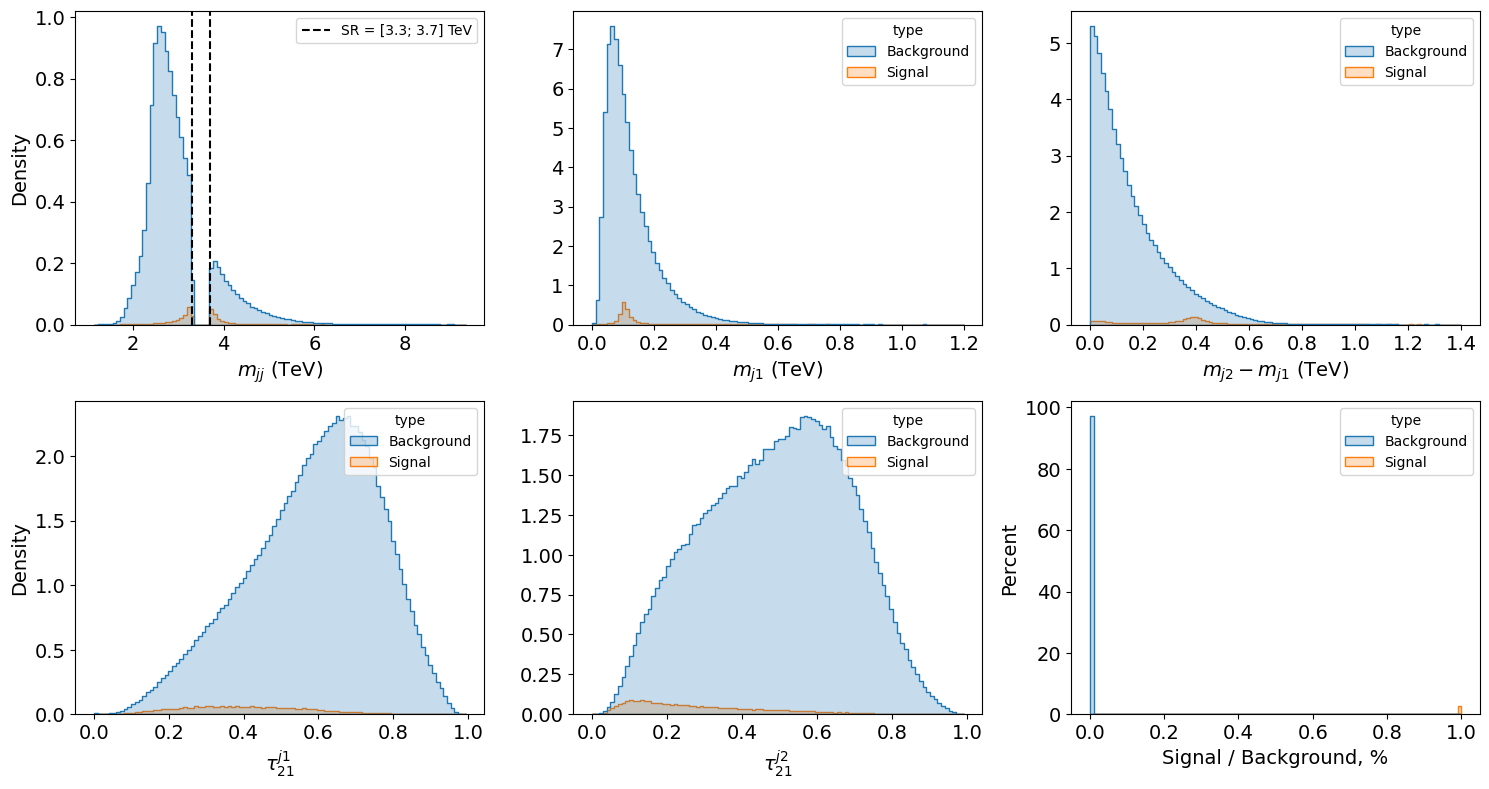

In [8]:
LHCO_SB = LHCO_RD_dataset.loc[(LHCO_RD_dataset['0'] < 3.3) | (LHCO_RD_dataset['0'] > 3.7)]
feature_hists(LHCO_SB, highlight_SR=True)

## Logit Scaling

In [9]:
class Logiter(object):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.x_max = None
        self.x_min = None
        
    def fit(self, X, y=None):
        self.x_min = np.min(X, axis=0)
        self.x_max = np.max(X, axis=0)
        self.mean = None
        self.std = None
        return self

    def logit_transform(self, data):
        data2 = (data - self.x_min) / (self.x_max - self.x_min)
        mask = np.prod((data2 > 0) & (data2 < 1), axis=1).astype(bool)
    
        data3 = data2[mask]
        data4 = np.log((data3) / (1 - data3))
        
        no_infs_logit = np.ma.masked_invalid(data4)
        no_inf_max = no_infs_logit.max(axis=0).data
        no_inf_min = no_infs_logit.min(axis=0).data
        data4 = np.clip(data4, no_inf_min, no_inf_max)

        if self.mean is None:
            self.mean = np.mean(data4, axis=0)
        if self.std is None:
            self.std = np.std(data4, axis=0)
        return (data4 - self.mean) / self.std, mask

    def logit_transform_inverse(self, data):
        data1 = data * self.std + self.mean
        dataout = (self.x_min + self.x_max * np.exp(data1)) / (1 + np.exp(data1))
        return dataout
    
    
def quick_logit(x):
    x_norm = (x - min(x)) / (max(x) - min(x))
    x_norm = x_norm[(x_norm != 0) & (x_norm != 1)]
    logit = np.log(x_norm / (1 - x_norm))
    logit = logit[~np.isnan(logit)]
    return logit

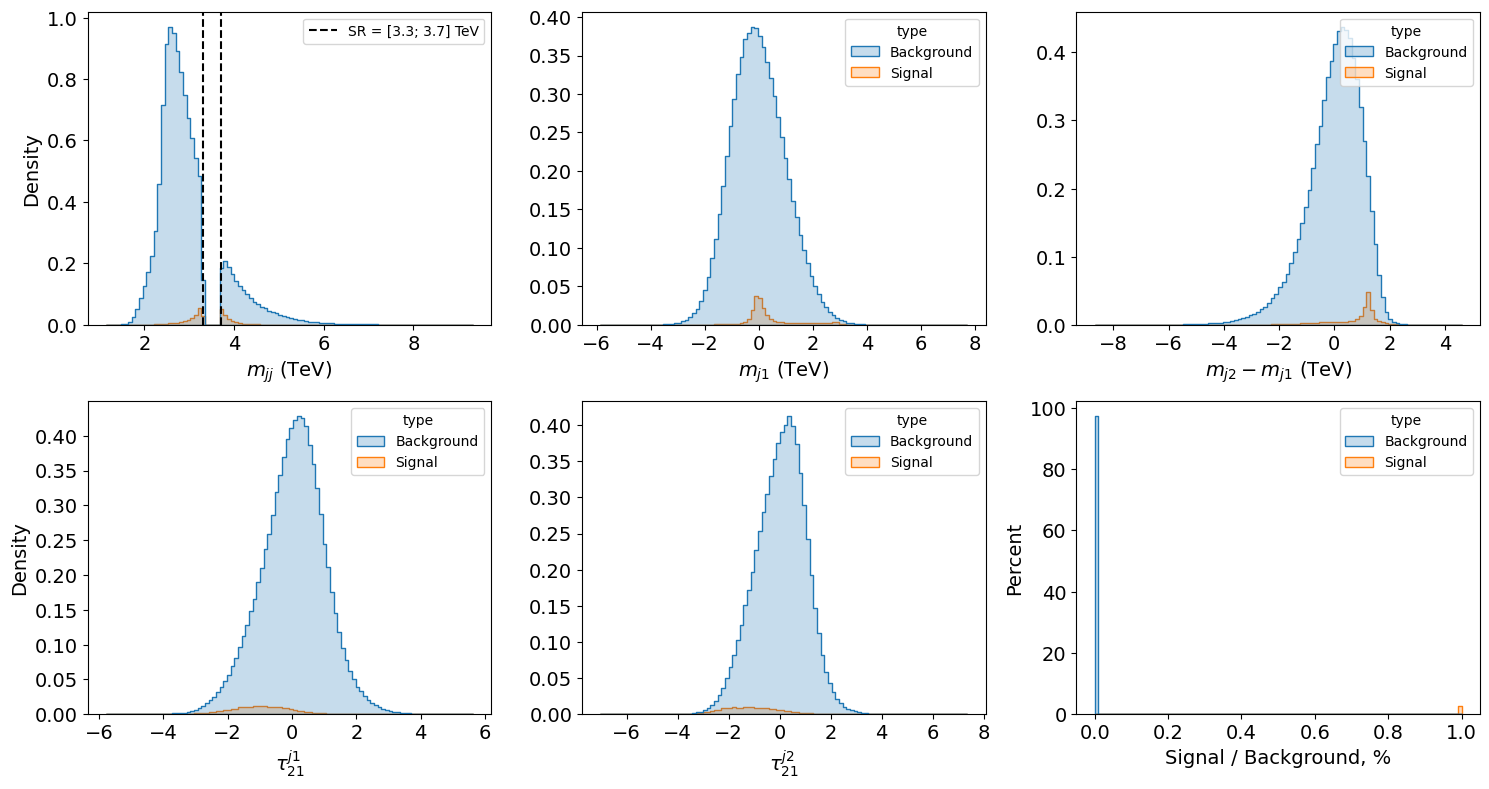

In [10]:
scaler = Logiter().fit(LHCO_SB[['1', '2', '3', '4']])

LHCO_SB_scaled = LHCO_SB.copy()
LHCO_SB_scaled[['1', '2', '3', '4']], mask = scaler.logit_transform(LHCO_SB_scaled[['1', '2', '3', '4']])
feature_hists(LHCO_SB_scaled.loc[mask], highlight_SR=True)

# Mock set (density estimation & interpolation)

In [11]:
mock_sr_train = pd.read_csv("../../data/mock/SR_train.csv")
mock_sr_val = pd.read_csv("../../data/mock/SR_val.csv")
mock_sb_train = pd.read_csv("../../data/mock/SB_train.csv")
mock_sb_val = pd.read_csv("../../data/mock/SB_val.csv")

full_mock = pd.concat([mock_sr_train, mock_sr_val, mock_sb_train, mock_sb_val], axis=0)
sr_mock = pd.concat([mock_sr_train, mock_sr_val], axis=0)
full_mock['5'].sum() / full_mock.shape[0]

0.0009931162626792514

## Full Domain

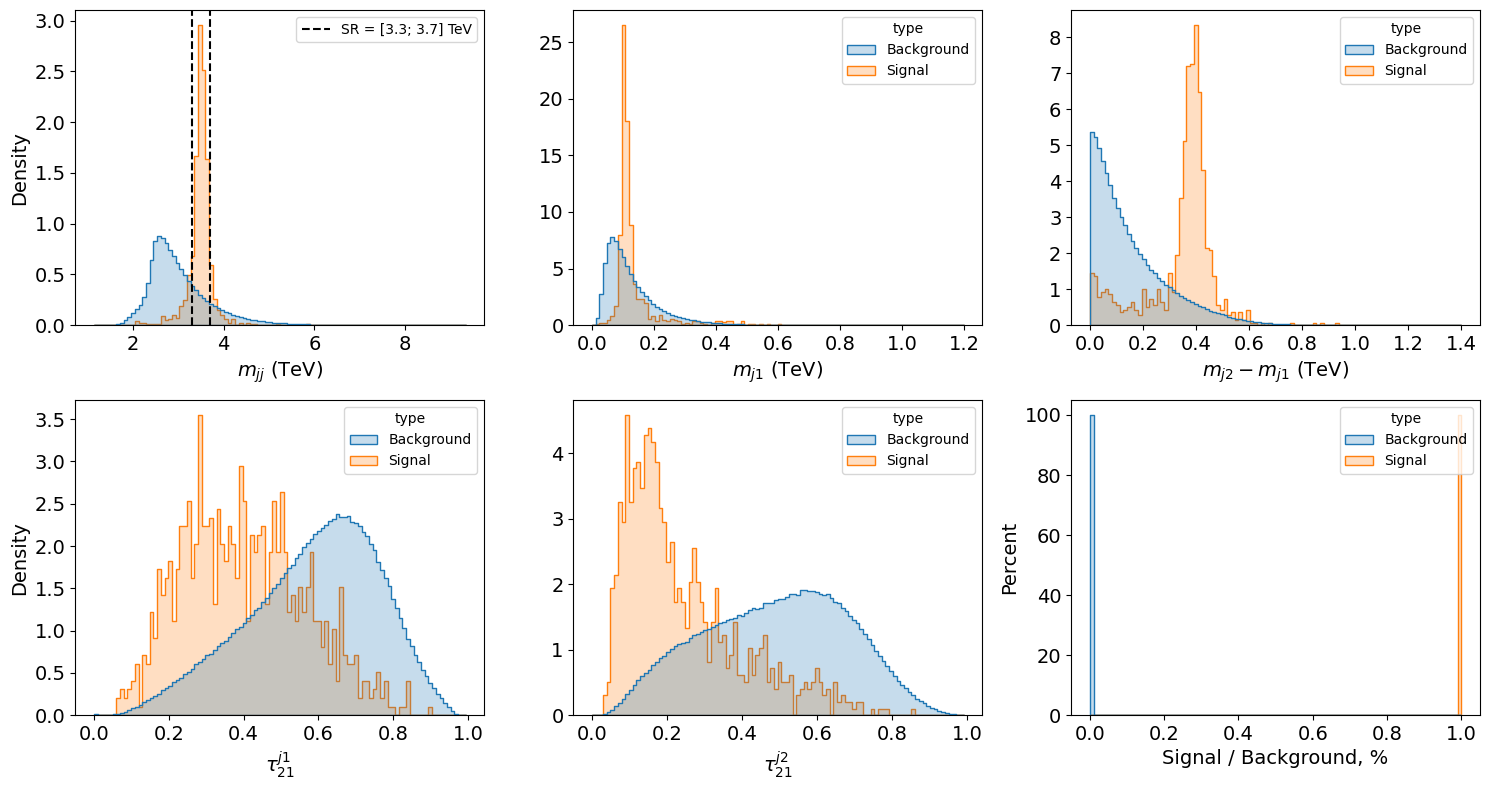

In [12]:
feature_hists(full_mock, common_norm=False, highlight_SR=True)

## Only SR

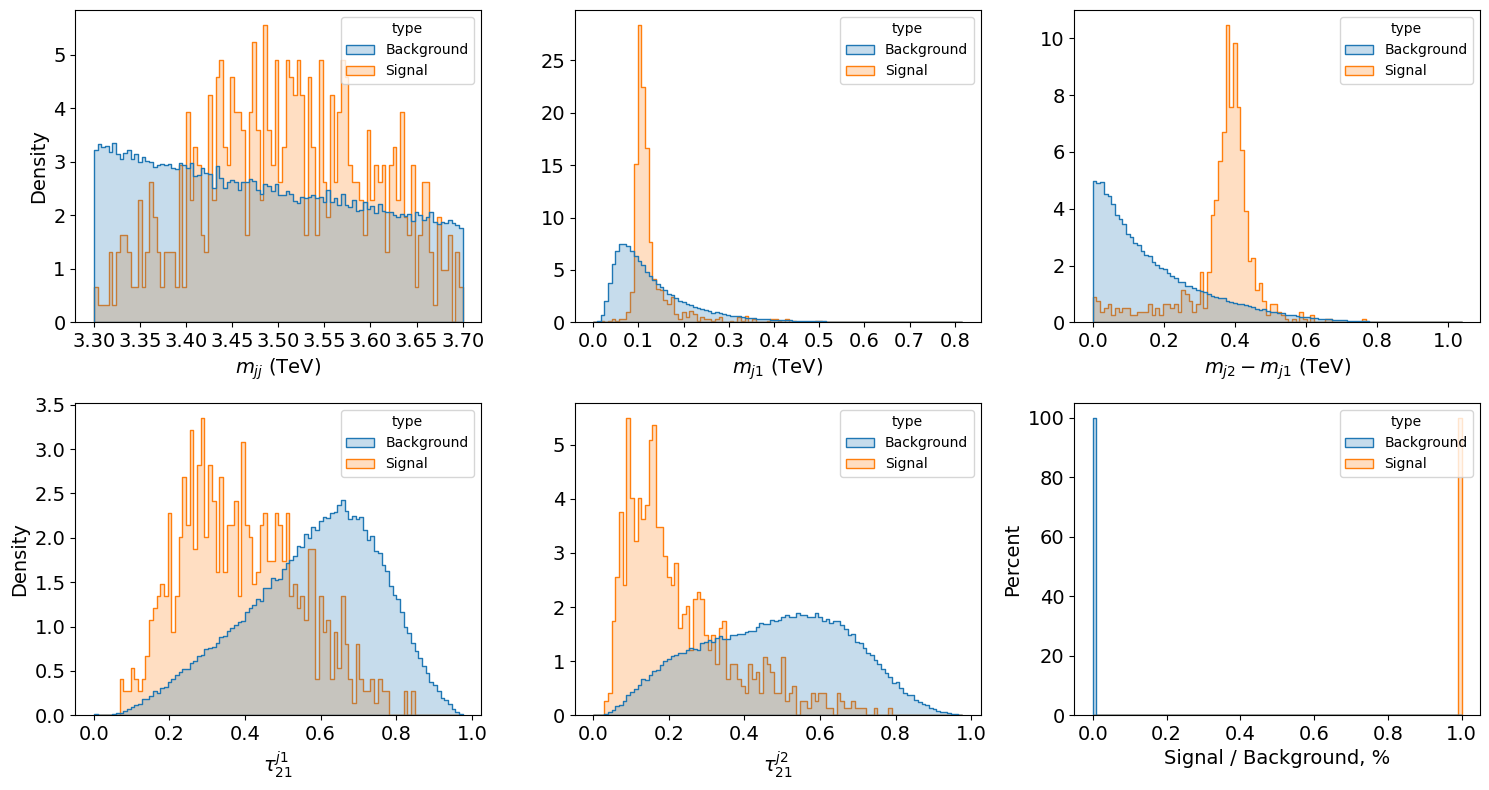

In [13]:
feature_hists(sr_mock, common_norm=False, highlight_SR=False)

# Evaluation set

In [14]:
SR_test = pd.read_csv("../../data/evaluation/SR_test.csv")
extrabg_SR_test = pd.read_csv("../../data/evaluation/extrabg_SR_test.csv")
test_data = pd.concat([SR_test, extrabg_SR_test])
test_data['5'].sum() / test_data.shape[0]

0.05555555555555555

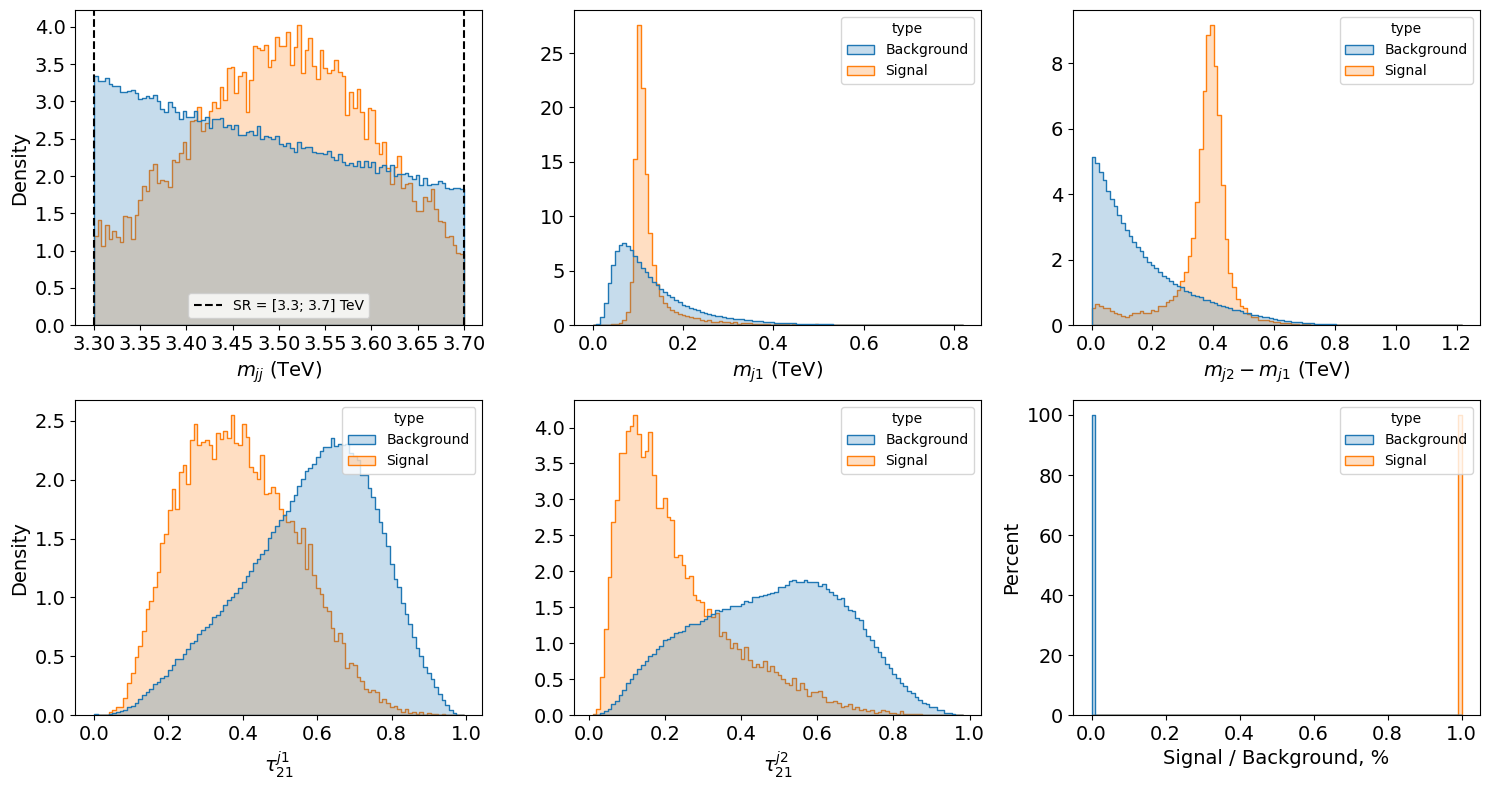

In [15]:
feature_hists(test_data, common_norm=False, highlight_SR=True)

# Simulation + Mock (Only SR)

In [16]:
sim_bg_train = pd.read_csv("../../data/simulation/extrabg_SR_train.csv")
sim_bg_val = pd.read_csv("../../data/simulation/extrabg_SR_val.csv")
sim_sig_train = pd.read_csv("../../data/simulation/extrasig_SR_train.csv")
sim_sig_val = pd.read_csv("../../data/simulation/extrasig_SR_val.csv")

full_simulation_SR = pd.concat([sim_bg_train, sim_bg_val, sim_sig_train, sim_sig_val], axis=0)
full_simulation_SR['5'].sum() / full_simulation_SR.shape[0]

0.16655314079753195

In [17]:
def plot_histograms(X_real, X_fake, labels=('Generated samples', 'Real samples',)):
    x_names = [r'$m_{jj}$ (TeV)', r'$m_{j1}$ (TeV)', r'$m_{j2}-m_{j1}$ (TeV)', r'$\tau_{21}^{j1}$', r'$\tau_{21}^{j2}$']

    plt.figure(figsize=(12, 15))
    for i in range(X_real.shape[1] - 1):
        j = (i + 1) % 5
        plt.subplot(3, 2, i + 1)
        bins = np.linspace(X_real[:, j].min(), X_real[:, j].max(), 101)
        plt.hist(X_fake[:, j], bins=bins, density=True, label=labels[0],
                 histtype='bar', color='cornflowerblue', alpha=0.6)
        plt.hist(X_real[:, j], bins=bins, density=True, label=labels[1],
                 histtype='step', color='C3', linewidth=1.5)
        plt.xlabel(x_names[j], size=14)
        plt.ylabel('Events (a.u.)', size=14)
        plt.xticks(size=14)
        plt.yticks(size=14)
        plt.legend()
    plt.tight_layout()
    plt.show()

## Only Backfround

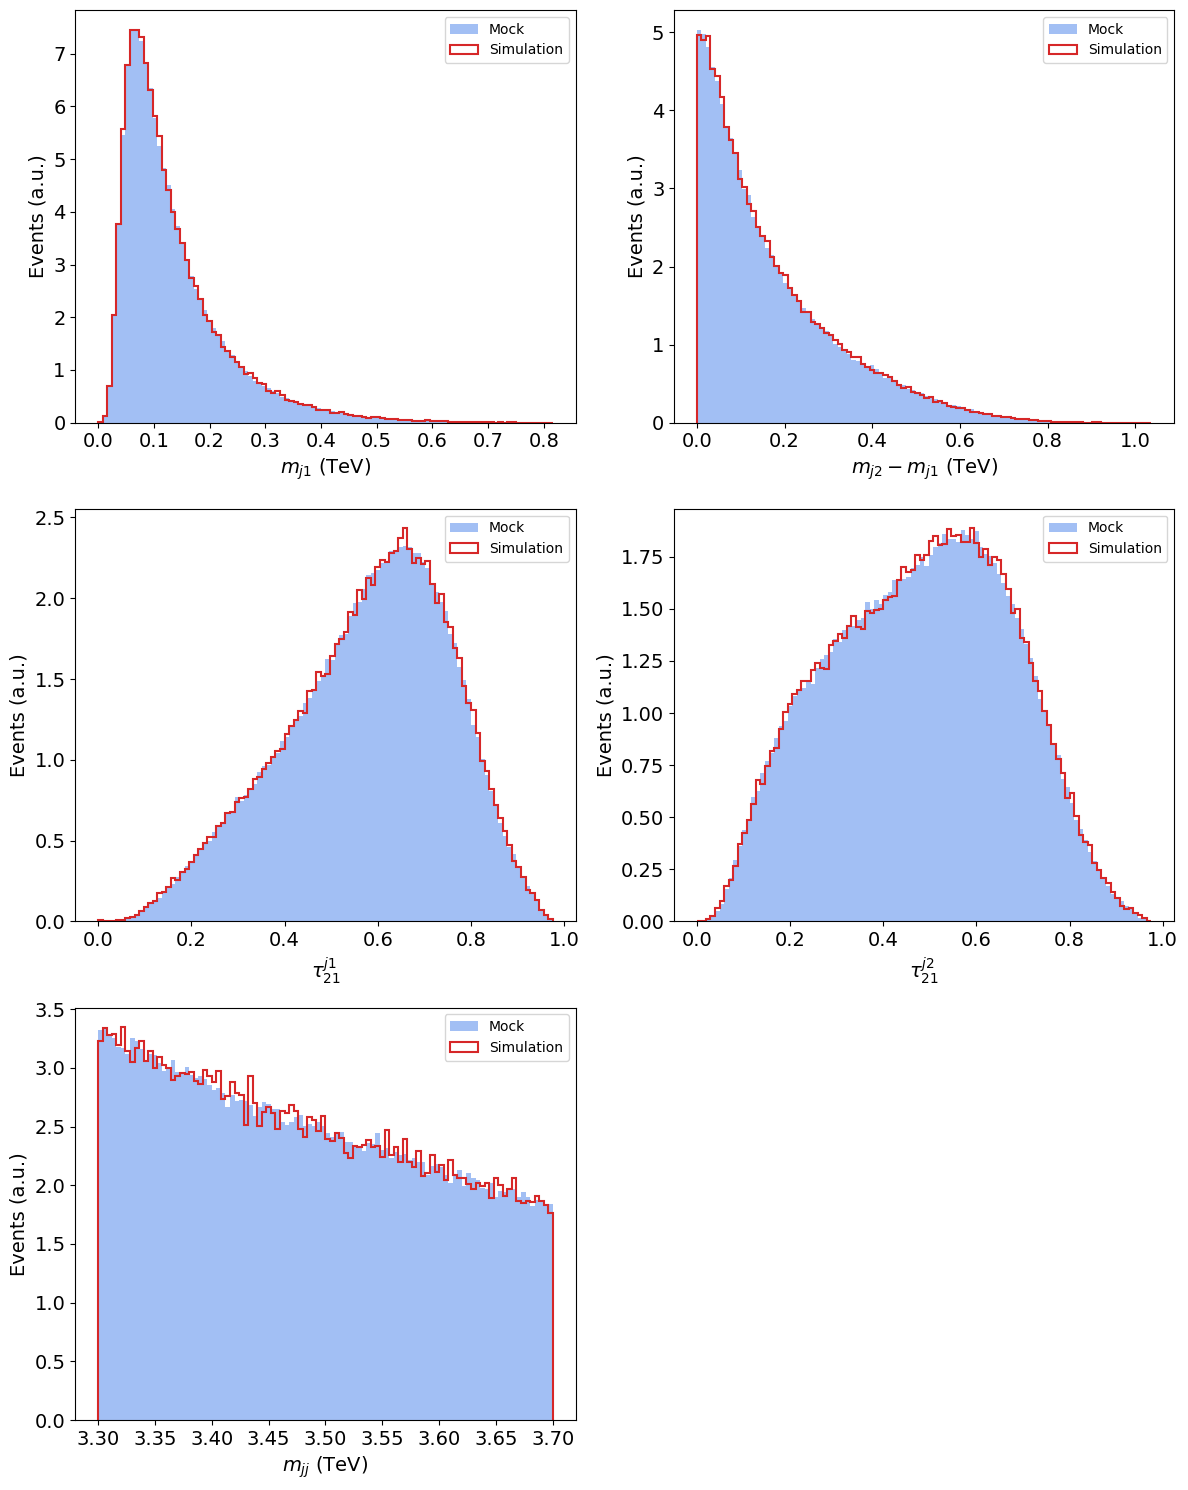

In [18]:
only_bg_mock = sr_mock[sr_mock['5'] == 0]
only_bg_sim = full_simulation_SR[full_simulation_SR['5'] == 0]

plot_histograms(only_bg_mock.to_numpy(), only_bg_sim.to_numpy(), labels=("Mock", "Simulation"))

## Only Signal

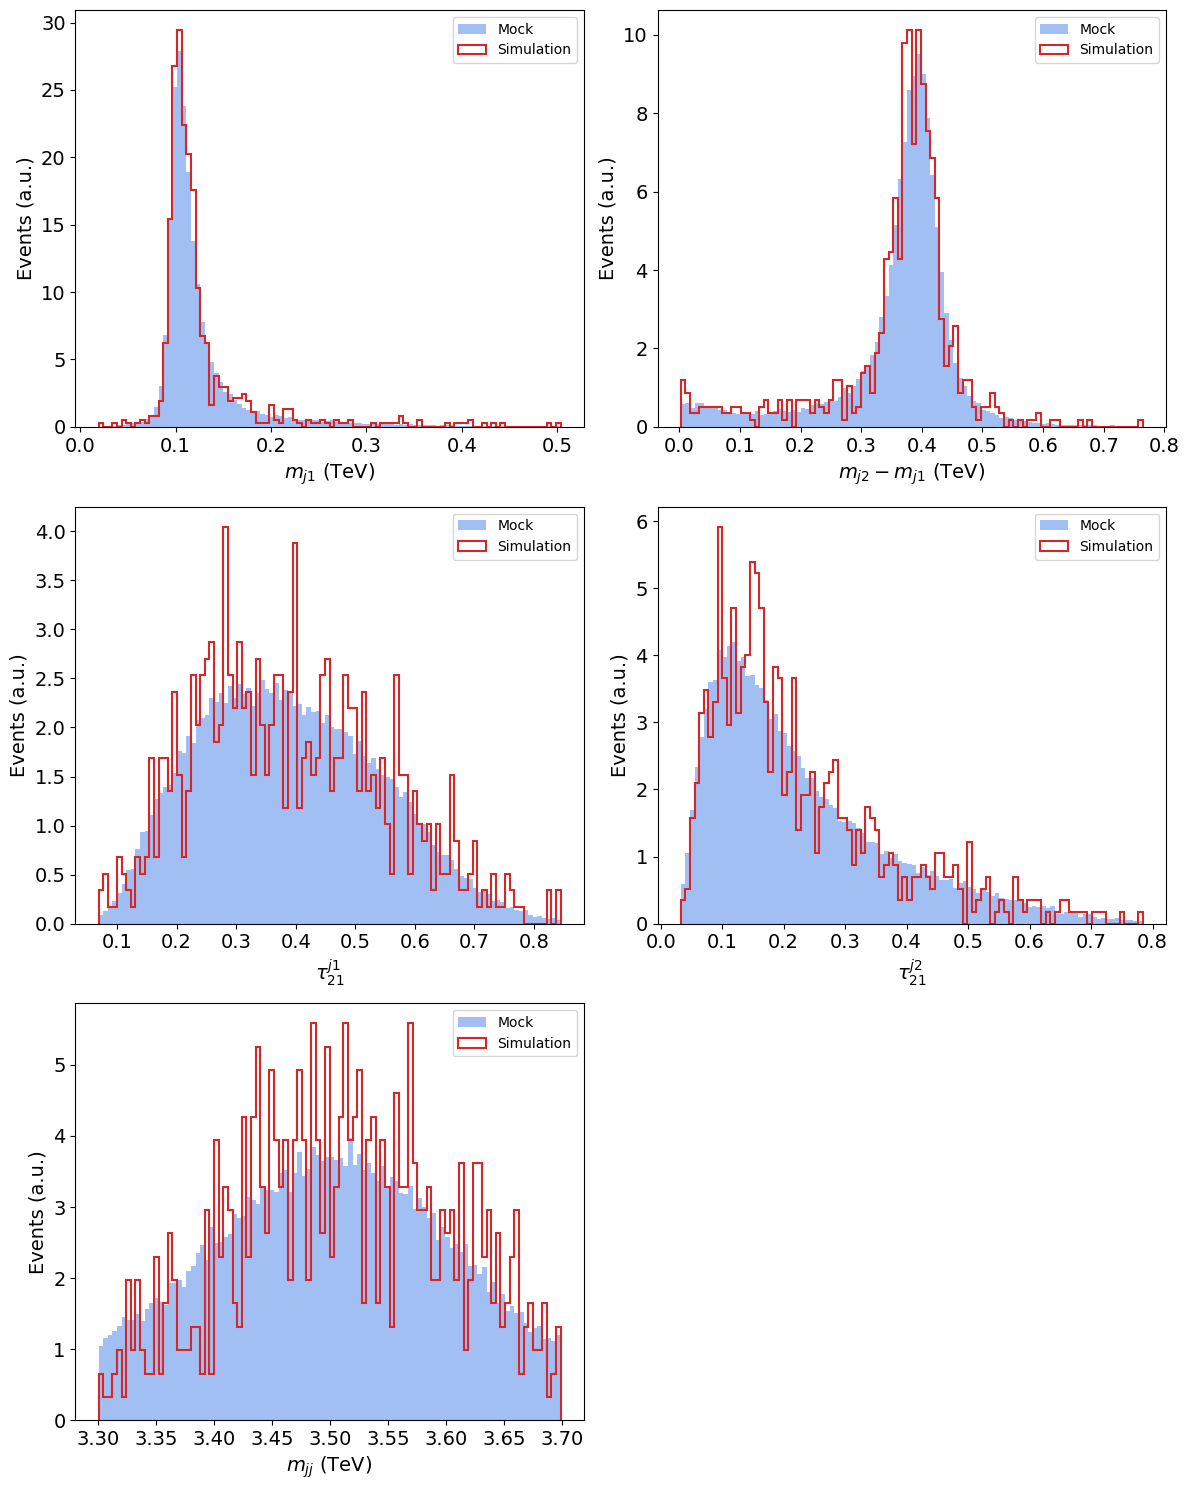

In [19]:
only_sig_mock = sr_mock[sr_mock['5'] == 1]
only_sig_sim = full_simulation_SR[full_simulation_SR['5'] == 1]

plot_histograms(only_sig_mock.to_numpy(), only_sig_sim.to_numpy(), labels=("Mock", "Simulation"))

# Idealized AD Data and Evaluation Set

In [20]:
iad_sr_train = pd.read_csv("../../data/mock/SR_train.csv")
iad_bkg_train = pd.read_csv("../../data/simulation/extrabg_SR_train.csv")
iad_sr_valid = pd.read_csv("../../data/mock/SR_val.csv")
iad_bkg_valid = pd.read_csv("../../data/simulation/extrabg_SR_val.csv")

iad_train = pd.concat([iad_sr_train, iad_bkg_train], axis=0)
iad_valid = pd.concat([iad_sr_valid, iad_bkg_valid], axis=0)
iad_train['5'].sum() / iad_train.shape[0], iad_train.shape[0]

(0.002010904703480647, 196429)

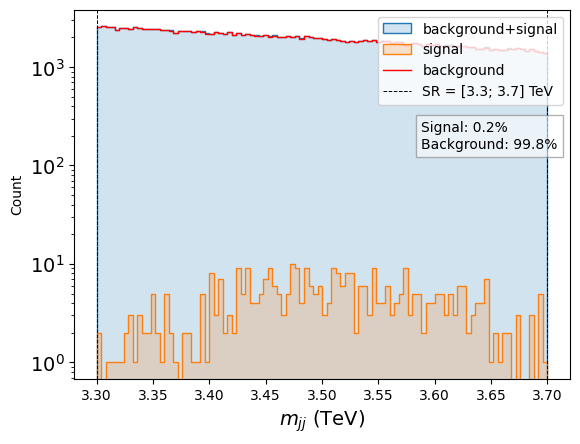

In [21]:
draw_mjj_log_scale(iad_train, is_SR=True)

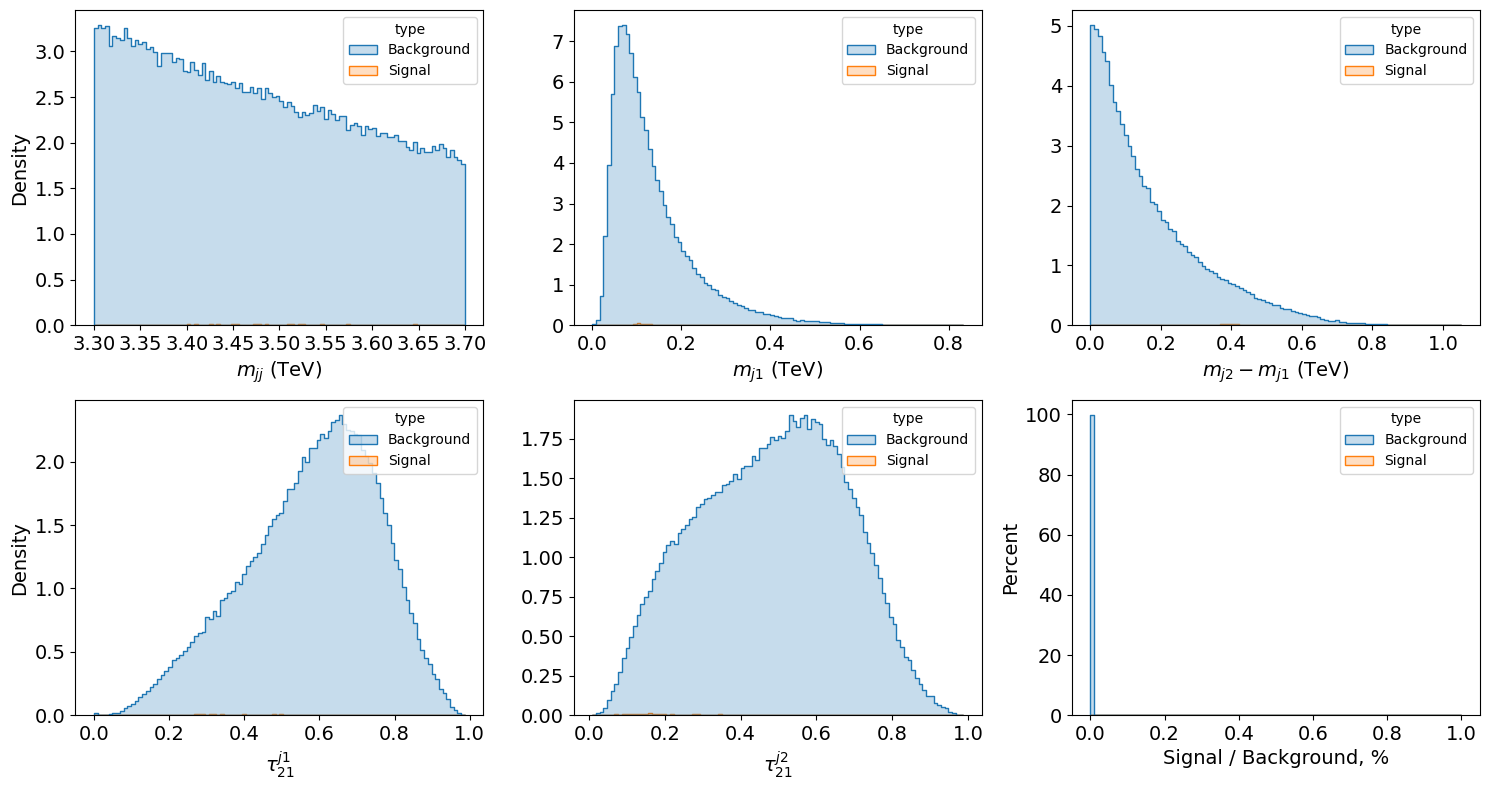

In [22]:
feature_hists(iad_train, common_norm=True, highlight_SR=False)

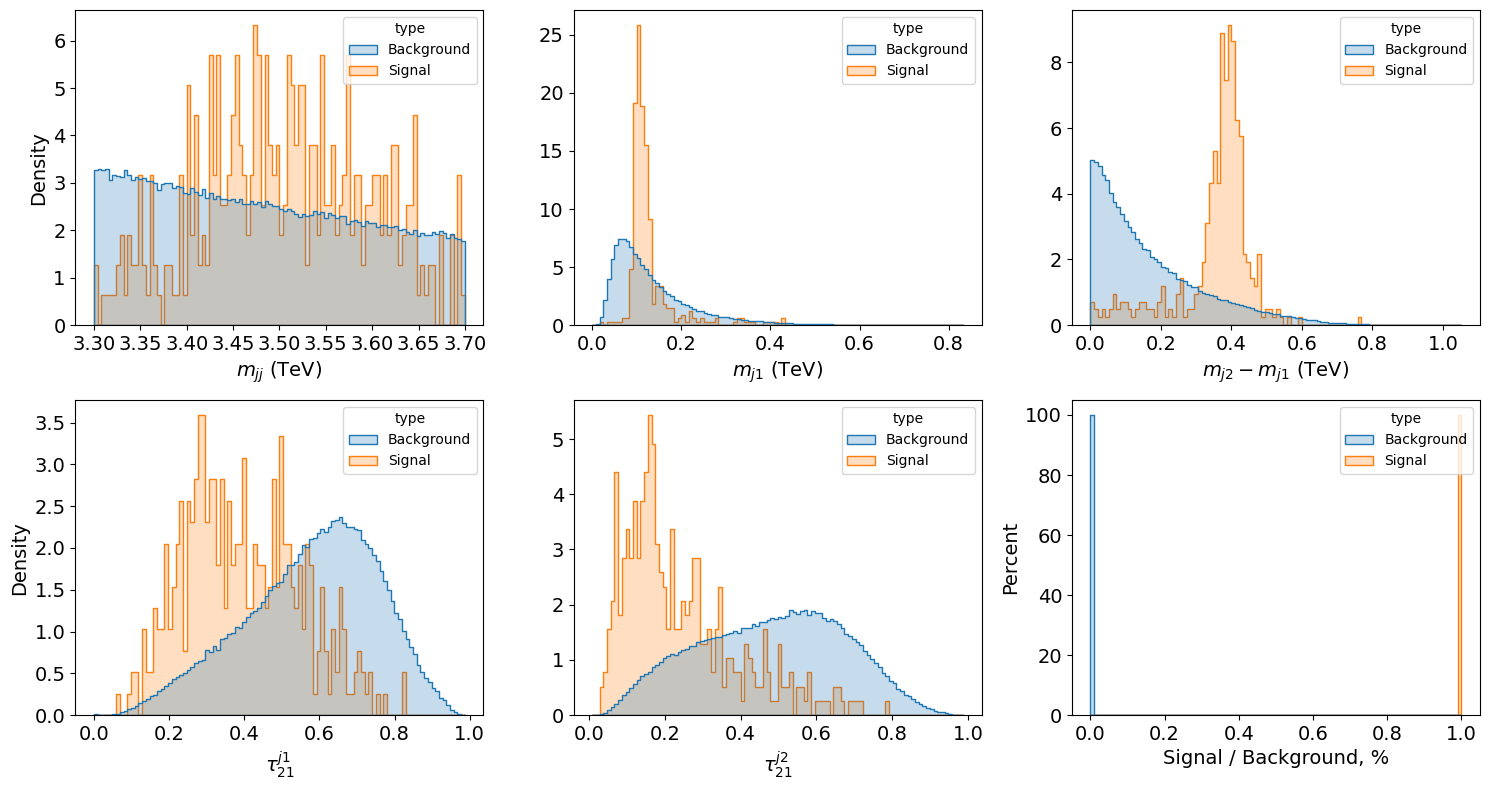

In [23]:
feature_hists(iad_train, common_norm=False, highlight_SR=False)

## Only Backfround

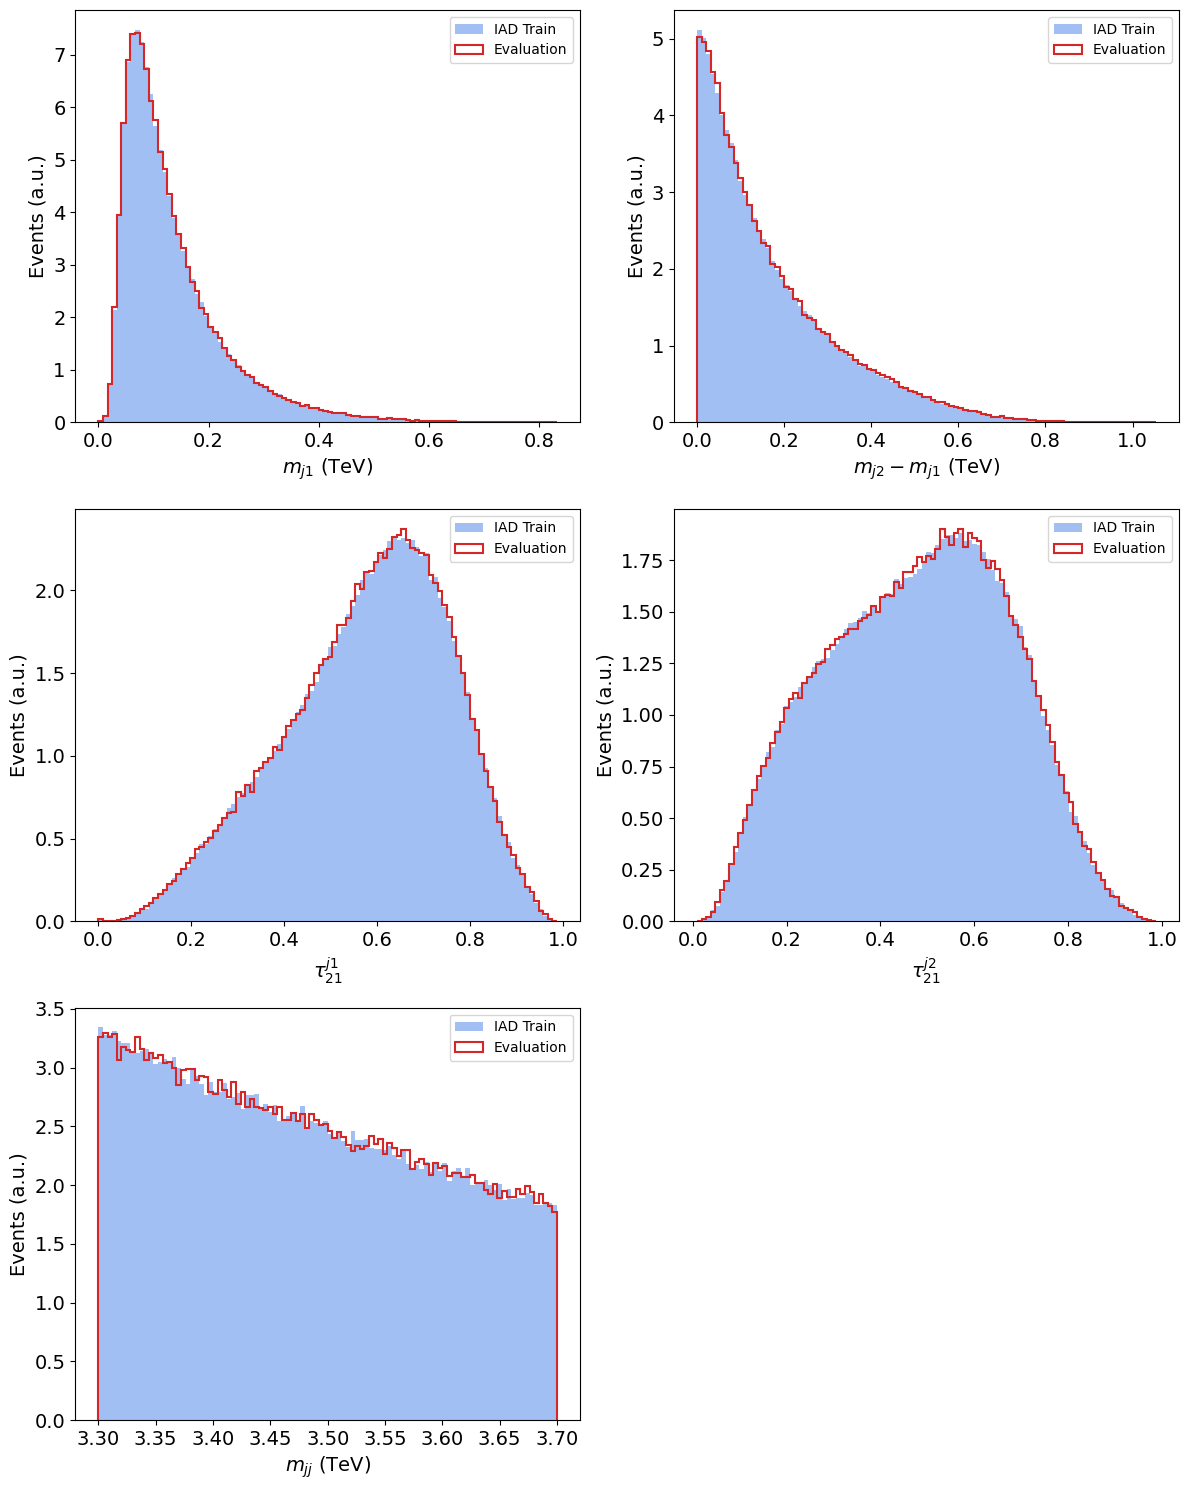

In [24]:
only_bg_iad = iad_train[iad_train['5'] == 0]
only_bg_eval = test_data[test_data['5'] == 0]

plot_histograms(only_bg_iad.to_numpy(), only_bg_eval.to_numpy(), labels=("IAD Train", "Evaluation"))

## Only Signal

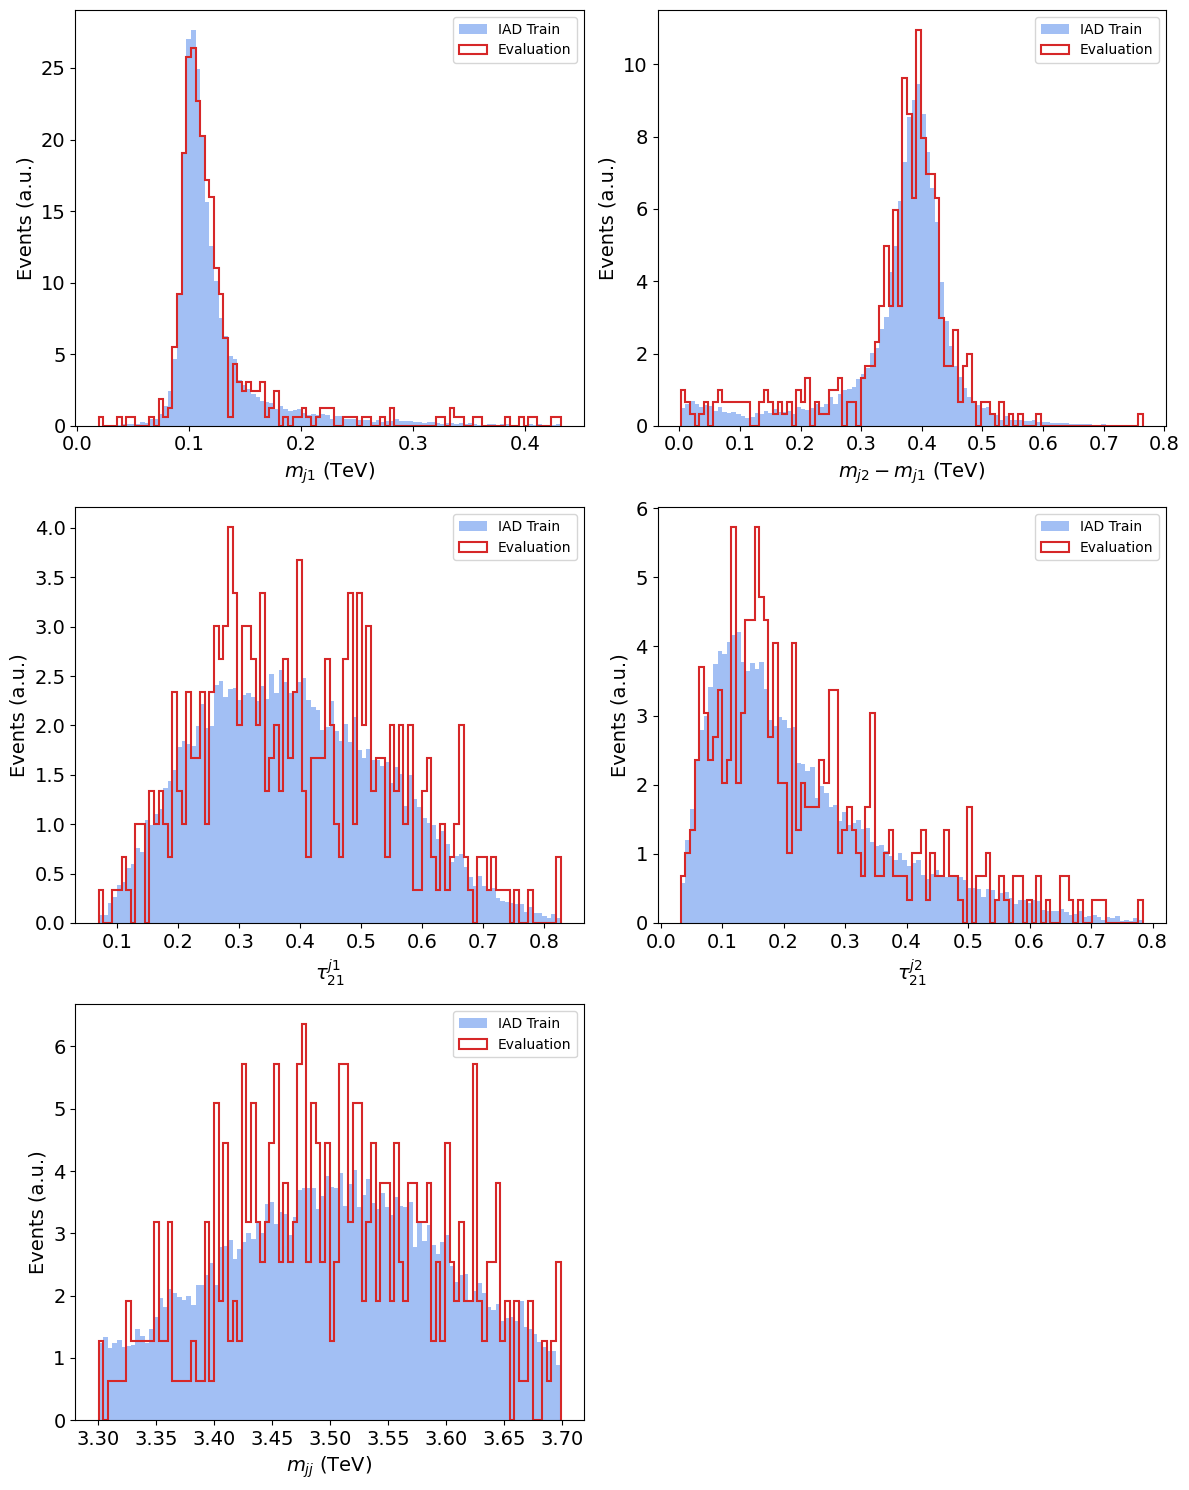

In [25]:
only_sig_iad = iad_train[iad_train['5'] == 1]
only_sig_eval = test_data[test_data['5'] == 1]

plot_histograms(only_sig_iad.to_numpy(), only_sig_eval.to_numpy(), labels=("IAD Train", "Evaluation"))